# Physik der sozio-ökonomischen Systeme mit dem Computer
# (Physics of Socio-Economic Systems with the Computer)

### Vorlesung gehalten an der J.W.Goethe-Universität in Frankfurt am Main 
#### (Wintersemester 2025/26)

### von Dr.phil.nat. Dr.rer.pol. Matthias Hanauske

### Frankfurt am Main 22.08.2025

### Erster Vorlesungsteil:  
#### Numerisches Lösen von Differentialgleichungen (das Anfangswertproblem)

Dieses Jupyter Notebook basiert auf den Materialien der Vorlesung "Einführung in die Programmierung für Studierende der Physik (Introduction to Programming for Physicists)" (siehe <A href="https://itp.uni-frankfurt.de/~hanauske/VPROG/index.html#V8" target="_blank">Vorlesung 8</A> ). Das Anfangswertproblem wird zunächst allgemein behandelt und am Ende auf die Differentialgleichung der Replikatordynamik der evolutionären Spieltheorie angewendet. 

## Allgemeine Betrachtungen

Zunächst wird das Python Modul "sympy" eingebunden, das ein Computer-Algebra-System für Python bereitstellt und eine Vielzahl an symbolischen Berechnungen im Bereich der Mathematik und Physik relativ einfach möglich macht (weiteres siehe Vorlesung 6 <A href="https://itp.uni-frankfurt.de/~hanauske/VPROG/Python/Jupyter/Jupyter_sympy.html" target="_blank">Jupyter Notebooks und das Rechnen mit symbolischen Ausdrücken</A>). Falls Sie das "sympy" Modul das erste Mal verwenden, müssen Sie es zunächst in Ihrer Python 3 Umgebung installieren (z.B. in einem Linux Terminal mit "pip3 install sympy").

In [1]:
from sympy import *
init_printing()

Wir betrachten in diesem Jupyter Notebook das numerische Lösen einer Differentialgleichung (DGL) erster Ordnung der Form 

$$
\begin{equation}
\dot{y}(t) = \frac{d y(t)}{dt} = f(t,y(t)) \quad, \, \hbox{mit:} \,\, a \leq t \leq b \, , \,\, y(a)=\alpha \quad.
\end{equation}
$$


Die Funktion $f(t,y(t))$ bestimmt die DGL und somit das Verhalten der gesuchten Funktion $y(t)$. Es wird hierbei vorausgesetzt, dass $f(t,y(t))$ auf einer Teilmenge ${\cal D}=\{ (t,y) | a \leq t \leq b \, , \,\,  -\infty \leq y \leq \infty \}$ kontinuierlich definiert ist. Weiter wird angenommen, dass so definierte Anfangswertproblem "well-posed" ist und eine eindeutige Lösung $y(t)$ existiert ("well-posed" bedeutet hier, dass die Differentialgleichung eine Struktur hat, bei der kleine Störungen im Anfangszustand nicht exponentiell anwachsen).

### Beispiel: Analytische Lösung
Wir betrachten im Folgenden die DGL:

$$
\begin{equation}
\frac{d y(t)}{dt} = f(t,y(t)) = y(t)-t^2 +1 \quad, \, \hbox{mit:} \,\, 0 \leq t \leq 2 \, , \,\, y(0)=\alpha = 0.5 \quad.
\end{equation}
$$

Zunächst definieren wir uns die DGL als sympy-Gleichung

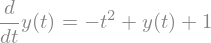

In [2]:
t= symbols('t',real=True)
y = Function('y')(t)
DGL = Eq(y.diff(t), y-t**2 +1)
DGL

und versuchen mittels des Befehls "dsolve()" eine allgemeine analytische Lösung zu finden: 

In [3]:
dsolve(DGL)

Die Konstante $C_1$ ist durch die oben angegebene Anfangsbedingung ($y(0)= \alpha$) bestimmt. Einarbeiten dieser Anfangsbedingung:

In [4]:
alpha= symbols('alpha')
y_0 = alpha
Loes_DGL = dsolve(DGL,ics={y.subs(t,0):y_0})
Loes_DGL

Diese allgemeine Lösung können wir später zum Vergleich in unserem C++ Programm verwenden. Wir schreiben sie somit als C++-Ausdruck:

In [5]:
print(ccode(Loes_DGL.rhs))

pow(t, 2) + 2*t + (alpha - 1)*exp(t) + 1


bzw.

In [6]:
from sympy.codegen.ast import Assignment
wert= symbols('wert')
print(ccode(Assignment(wert, Loes_DGL.rhs)))

wert = pow(t, 2) + 2*t + (alpha - 1)*exp(t) + 1;


Es wird somit eine allgemeine analytische Lösung gefunden, sodass wir die spezielle Anfangsbedingung ($y(0)= 0.5$, $\alpha=0.5$) einarbeiten können, um den noch unbestimmten Parameter $C_1$ bzw. $\alpha$ festzulegen.

In [7]:
y_0 = 0.5
Loes_DGL = dsolve(DGL,ics={y.subs(t,0):y_0})
Loes_DGL

Wir stellen uns die berechnete analytische Lösung der DGL dar:

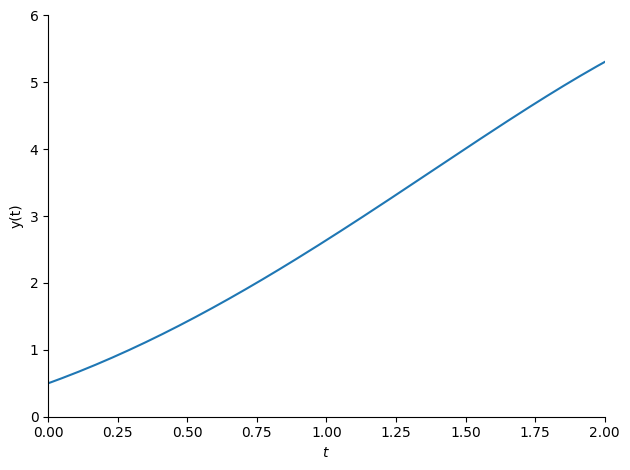

In [8]:
plot(Loes_DGL.rhs,xlim=(0,2),ylim=(0,6),ylabel="y(t)");

### Beispiel: Numerische Lösung 
Nicht jede DGL lässt sich analytisch lösen und falls der Befehl "dsolve()" keine sinnvollen Resultate liefert, muss man die zeitliche Entwicklung der Funktion $y(t)$ numerisch berechnen. Um zu verdeutlichen, wie eine solche numerische Lösung erzeugt wird, benutzen wir die DGL aus dem vorigen Beispiel (obwohl man hier eine analytische Lösung findet). 

Wir benutzen hierfür das Python-Modul <A href="https://docs.scipy.org/doc/scipy/tutorial/index.html#user-guide" target="_blank">SciPy</A>, welches eine breite Kollektion von mathematischen Algorithmen und Funktionen bereitstellt. Im Speziellen werden wir die Funktion <A href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp" target="_blank">'solve_ivp(...)'</A> verwenden, die sich im Untermodul <A href="https://docs.scipy.org/doc/scipy/reference/integrate.html#module-scipy.integrate" target="_blank">'scipy.integrate'</A> befindet, welches Funktionen zum Lösen von gewöhnlichen Differentialgleichungen bereitstellt. Zusätzlich berechnen wir die numerische Lösung auch mittels der älteren Methode "integrate.odeint()", die ebenfalls in dem Python-Modul "scipy" definiert ist. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
from scipy import integrate

Wir definieren uns die DGL als eine Funktion

In [10]:
def DGL_num(t, y):
    dxdt = y-t**2 +1
    return dxdt

Zusätzlich auch für die ältere Methode "integrate.odeint()"

In [11]:
def DGL_num_odeint(y,t):
    dydt = y-t**2 +1
    return dydt

und lösen das Anfangswertproblem im Bereich $t \in [0,2]$ unter Verwendung von $N=1000$ zeitlichen Gitterpunkten (mesh points).

In [12]:
N = 1000
tval = np.linspace(0, 2, N)
Loes_DGL_num = integrate.solve_ivp(DGL_num, [0, 2], [y_0], t_eval=tval)

Zusätzlich auch für die Methode "integrate.odeint()"

In [13]:
Loes_DGL_num_odeint = integrate.odeint(DGL_num_odeint, y_0, tval)

Wir stellen uns die numerische Lösung grafisch dar:

In [14]:
params = {
    'figure.figsize'    : [8,5],
#    'text.usetex'       : True,
    'axes.titlesize' : 14,
    'axes.labelsize' : 16,  
    'xtick.labelsize' : 14 ,
    'ytick.labelsize' : 14 
}
matplotlib.rcParams.update(params) 

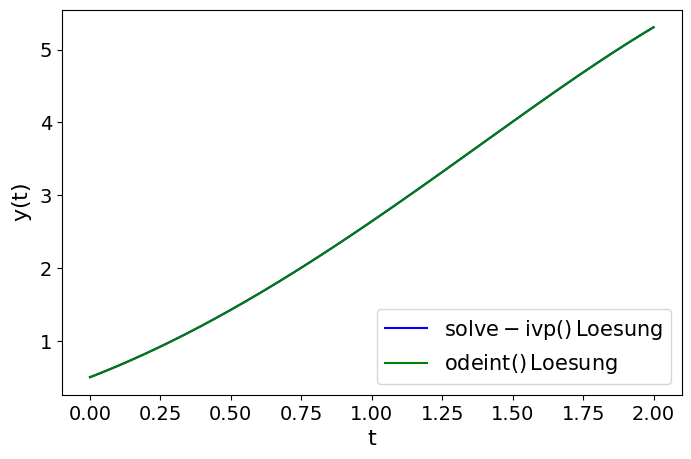

In [15]:
plt.xlabel(r"$\rm t$")
plt.ylabel(r"$\rm y(t)$")
plt.plot(Loes_DGL_num.t, Loes_DGL_num.y[0],c="blue", label=r'$\rm solve-ivp() \, Loesung$')
plt.plot(tval, Loes_DGL_num_odeint,c="green", label=r'$\rm odeint() \, Loesung$')
plt.legend(frameon=True, loc="lower right",fontsize=15);

Wir stellen uns den Fehler $\Delta y$ der simulierten Datenpunkte zur analytischen Lösung dar ($\Delta y = y_{analytisch}-y$):

In [16]:
Loes_DGL_lam = lambdify(t, Loes_DGL.rhs)

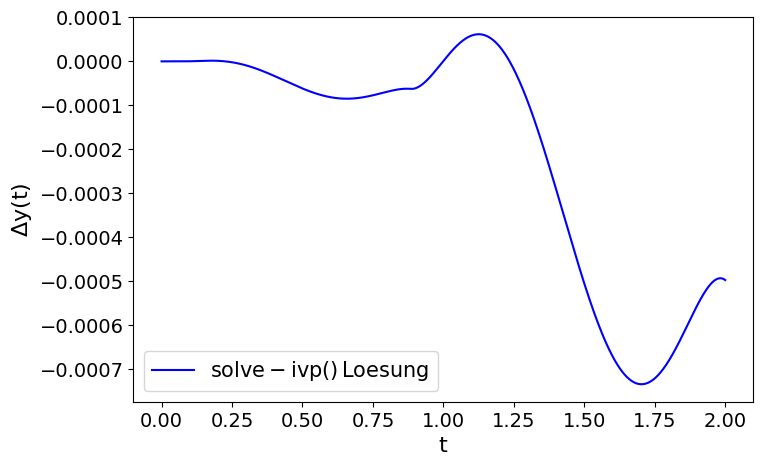

In [17]:
plt.xlabel(r"$\rm t$")
plt.ylabel(r"$\rm \Delta y(t)$")
plt.plot(Loes_DGL_num.t, Loes_DGL_lam(Loes_DGL_num.t) - Loes_DGL_num.y[0],c="blue", label=r'$\rm solve-ivp() \, Loesung$')
plt.legend(frameon=True, loc="lower left",fontsize=15);

und zusätzlich auch für die Methode "integrate.odeint()"

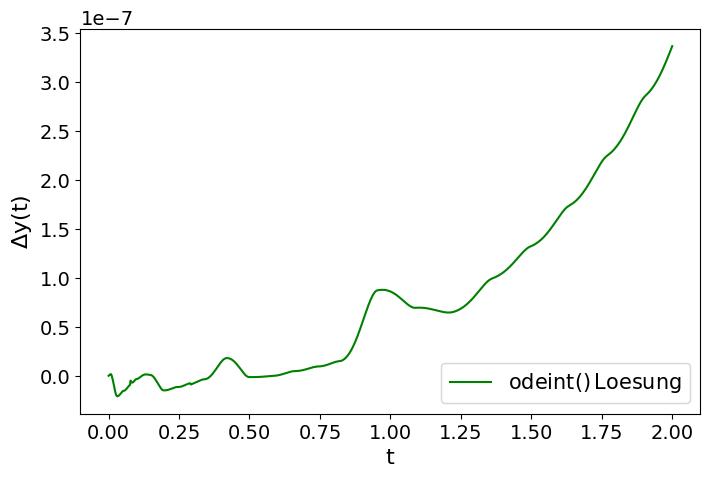

In [18]:
plt.xlabel(r"$\rm t$")
plt.ylabel(r"$\rm \Delta y(t)$")
plt.plot(tval, Loes_DGL_lam(tval) - Loes_DGL_num_odeint[:,0],c="green", label=r'$\rm odeint() \, Loesung$')
plt.legend(frameon=True, loc="lower right",fontsize=15);

Wir vergleichen diese numerische Lösung mit den Resultaten des C++ Programms <A href="https://itp.uni-frankfurt.de/~hanauske/VPROG/C++/DGL_1.cpp" target="_blank">DGL_1.cpp</A>. Wobei wir bei der Erzeugung der Daten zunächst nur 10 Gitterpunkte verwendeten und die Ergebnisse in eine Datei "DGL_1.dat" schrieben.

In [19]:
data = np.genfromtxt("./DGL_1.dat")

In [20]:
import matplotlib.gridspec as gridspec
# Bildabmessungen usw.
params = {
    'figure.figsize'    : [14,10],
    'text.usetex'       : True,
    'axes.titlesize' : 14,
    'axes.labelsize' : 16,  
    'xtick.labelsize' : 14 ,
    'ytick.labelsize' : 14 
}
matplotlib.rcParams.update(params) 

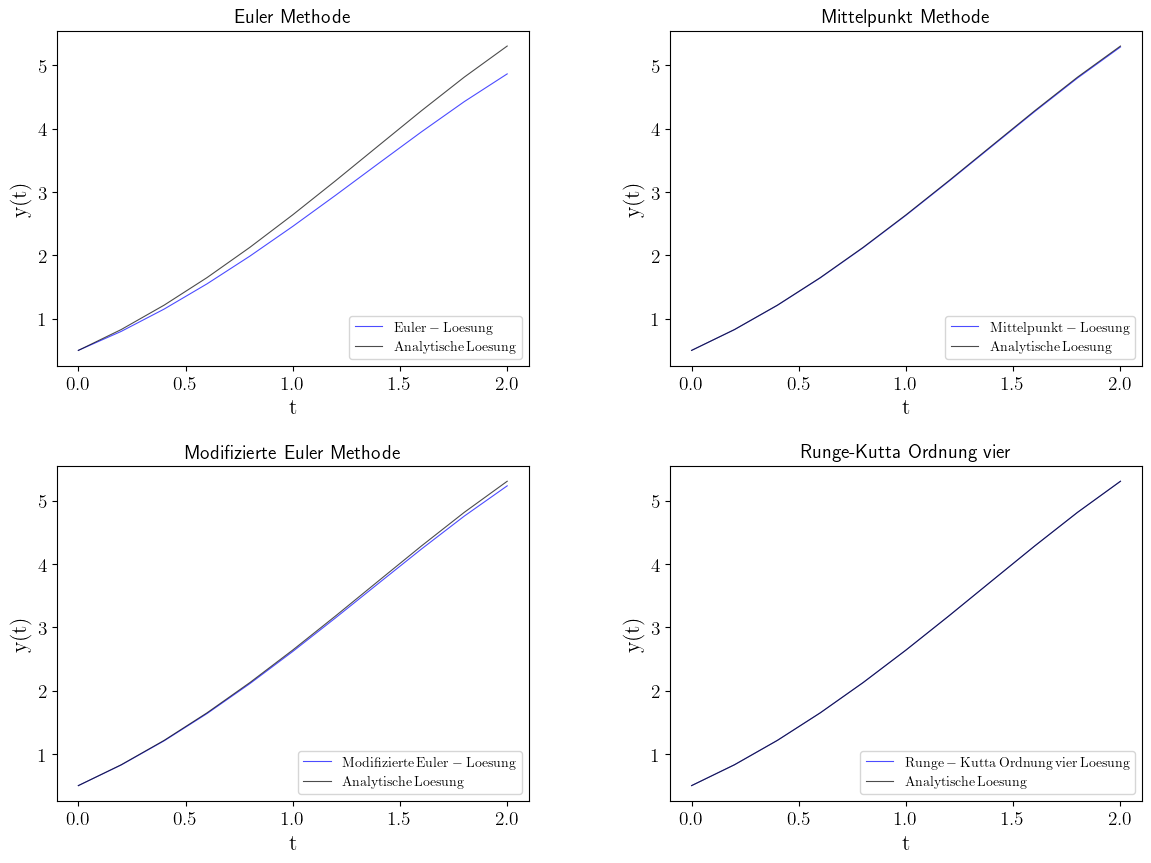

In [21]:
fig = plt.figure()                                                        # Hauptbild
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], wspace=0.3, hspace=0.3)  # Anordnung der vier Unterbilder
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

ax1.set_title(r'Euler Methode')                      # Titel der Abbildung in ax1
ax1.set_xlabel(r"$\rm t$")
ax1.set_ylabel(r"$\rm y(t)$")
ax2.set_title(r'Mittelpunkt Methode')                # Titel der Abbildung in ax2 
ax2.set_xlabel(r"$\rm t$")
ax2.set_ylabel(r"$\rm y(t)$")
ax3.set_title(r'Modifizierte Euler Methode')         # Titel der Abbildung in ax3  
ax3.set_xlabel(r"$\rm t$")
ax3.set_ylabel(r"$\rm y(t)$")
ax4.set_title(r'Runge-Kutta Ordnung vier')           # Titel der Abbildung in ax4  
ax4.set_xlabel(r"$\rm t$")
ax4.set_ylabel(r"$\rm y(t)$")

l_width = 0.8                                        # Festlegung der Plot-Liniendicke  
alp = 0.7                                            # Festlegung der Transparenz der Kurven

ax1.plot(data[:,1],data[:,2], color="blue", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Euler-Loesung$')
ax1.plot(data[:,1],data[:,6], color="black", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Analytische \, Loesung$') 

ax2.plot(data[:,1],data[:,3], color="blue", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Mittelpunkt-Loesung$')
ax2.plot(data[:,1],data[:,6], color="black", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Analytische \, Loesung$')

ax3.plot(data[:,1],data[:,4], color="blue", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Modifizierte \,Euler-Loesung$')
ax3.plot(data[:,1],data[:,6], color="black", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Analytische \, Loesung$')

ax4.plot(data[:,1],data[:,5], color="blue", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Runge-Kutta \, Ordnung \, vier \, Loesung$')
ax4.plot(data[:,1],data[:,6], color="black", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Analytische \, Loesung$')

ax1.legend(frameon=True, loc="lower right",fontsize=10)  # Anordnung der Legende auf ax1
ax2.legend(frameon=True, loc="lower right",fontsize=10)  # Anordnung der Legende auf ax2
ax3.legend(frameon=True, loc="lower right",fontsize=10)  # Anordnung der Legende auf ax3
ax4.legend(frameon=True, loc="lower right",fontsize=10); # Anordnung der Legende auf ax4

Wir stellen uns den Fehler $\Delta y$ der simulierten Datenpunkte zur analytischen Lösung dar ($\Delta y = y_{analytisch}-y$):

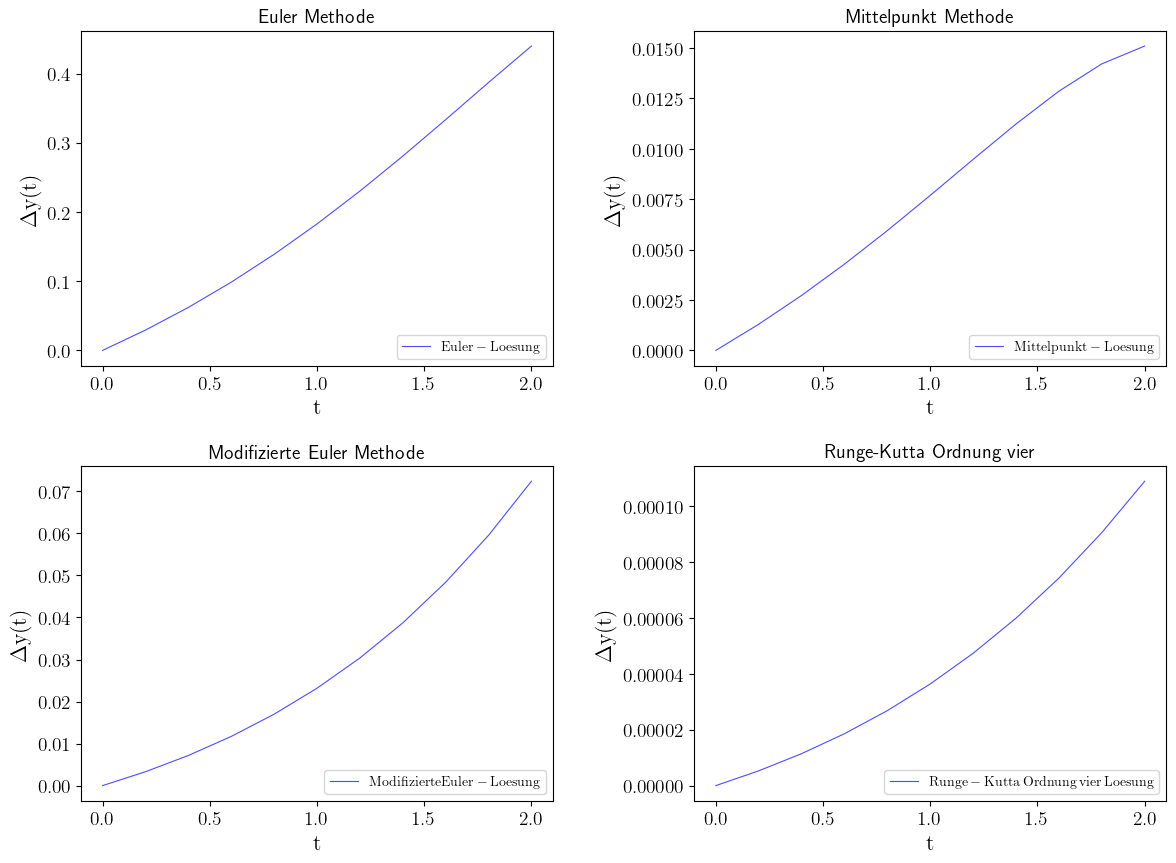

In [22]:
fig = plt.figure()                                                        # Hauptbild
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], wspace=0.3, hspace=0.3)  # Anordnung der vier Unterbilder
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

ax1.set_title(r'Euler Methode')                      # Titel der Abbildung in ax1
ax1.set_xlabel(r"$\rm t$")
ax1.set_ylabel(r"$\rm \Delta y(t)$")
ax2.set_title(r'Mittelpunkt Methode')                # Titel der Abbildung in ax2 
ax2.set_xlabel(r"$\rm t$")
ax2.set_ylabel(r"$\rm \Delta y(t)$")
ax3.set_title(r'Modifizierte Euler Methode')         # Titel der Abbildung in ax3  
ax3.set_xlabel(r"$\rm t$")
ax3.set_ylabel(r"$\rm \Delta y(t)$")
ax4.set_title(r'Runge-Kutta Ordnung vier')           # Titel der Abbildung in ax4  
ax4.set_xlabel(r"$\rm t$")
ax4.set_ylabel(r"$\rm \Delta y(t)$")

l_width=0.8                                          # Festlegung der Plot-Liniendicke  
alp=0.7                                              # Festlegung der Transparenz der Kurven


ax1.plot(data[:,1],data[:,6]-data[:,2], color="blue", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Euler-Loesung$')
ax2.plot(data[:,1],data[:,6]-data[:,3], color="blue", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Mittelpunkt-Loesung$')
ax3.plot(data[:,1],data[:,6]-data[:,4], color="blue", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Modifizierte Euler-Loesung$')
ax4.plot(data[:,1],data[:,6]-data[:,5], color="blue", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Runge-Kutta \, Ordnung \, vier \, Loesung$')

ax1.legend(frameon=True, loc="lower right",fontsize=10)  # Anordnung der Legende auf ax1
ax2.legend(frameon=True, loc="lower right",fontsize=10)  # Anordnung der Legende auf ax2
ax3.legend(frameon=True, loc="lower right",fontsize=10)  # Anordnung der Legende auf ax3
ax4.legend(frameon=True, loc="lower right",fontsize=10); # Anordnung der Legende auf ax4

Wir erhöhen nun die Anzahl der Gitterpunkte ($N=10000$) und betrachten uns wieder den Fehler $\Delta y$.

In [23]:
data = np.genfromtxt("./DGL_1a.dat")

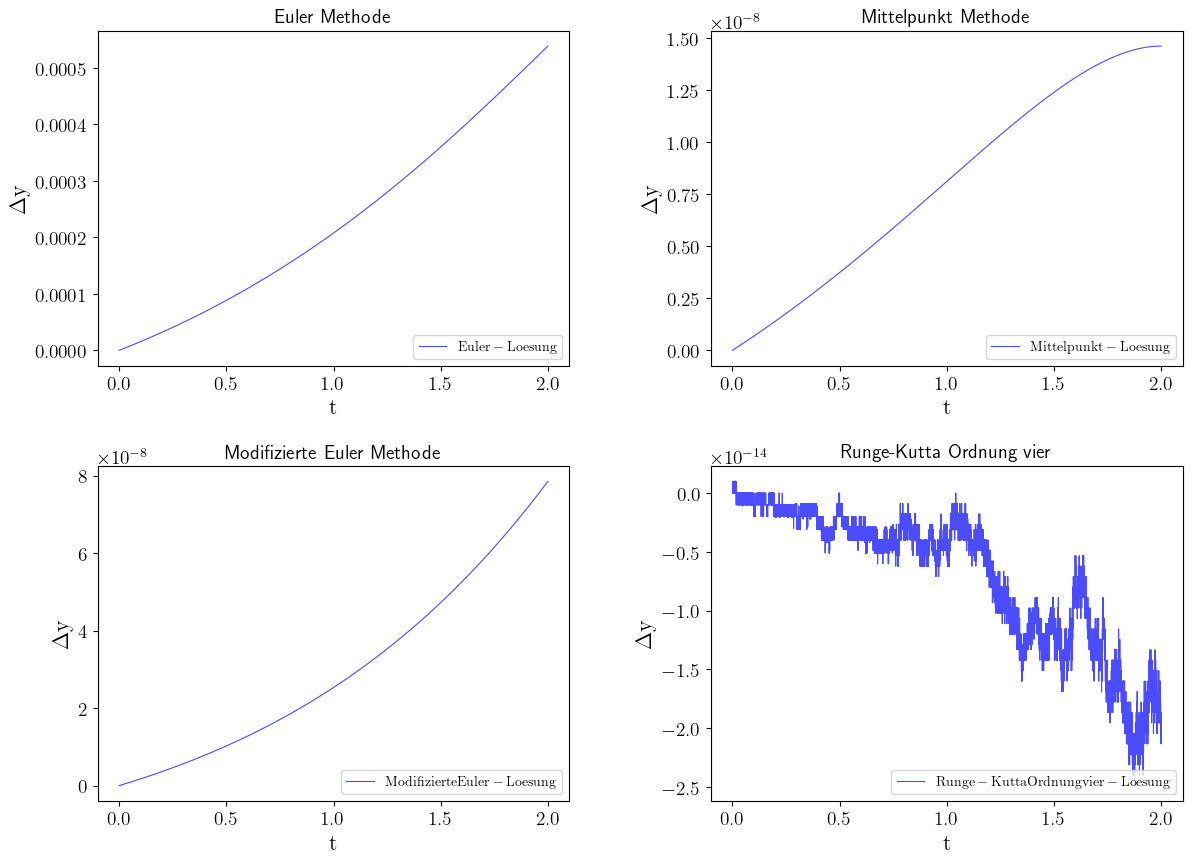

In [24]:
fig = plt.figure()                                                        # Hauptbild
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], wspace=0.3, hspace=0.3)  # Anordnung der vier Unterbilder
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

ax1.set_title(r'Euler Methode')                      # Titel der Abbildung in ax1
ax1.set_xlabel(r"$\rm t$")
ax1.set_ylabel(r"$\rm \Delta y$")
ax2.set_title(r'Mittelpunkt Methode')                # Titel der Abbildung in ax2 
ax2.set_xlabel(r"$\rm t$")
ax2.set_ylabel(r"$\rm \Delta y$")
ax3.set_title(r'Modifizierte Euler Methode')         # Titel der Abbildung in ax3  
ax3.set_xlabel(r"$\rm t$")
ax3.set_ylabel(r"$\rm \Delta y$")
ax4.set_title(r'Runge-Kutta Ordnung vier')           # Titel der Abbildung in ax4  
ax4.set_xlabel(r"$\rm t$")
ax4.set_ylabel(r"$\rm \Delta y$")

l_width=0.8                                          # Festlegung der Plot-Liniendicke  
alp=0.7                                              # Festlegung der Transparenz der Kurven

ax1.plot(data[:,1],data[:,6]-data[:,2], color="blue", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Euler-Loesung$')
ax2.plot(data[:,1],data[:,6]-data[:,3], color="blue", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Mittelpunkt-Loesung$')
ax3.plot(data[:,1],data[:,6]-data[:,4], color="blue", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Modifizierte Euler-Loesung$')
ax4.plot(data[:,1],data[:,6]-data[:,5], color="blue", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Runge-Kutta Ordnung vier-Loesung$')

ax1.legend(frameon=True, loc="lower right",fontsize=10)  # Anordnung der Legende auf ax1
ax2.legend(frameon=True, loc="lower right",fontsize=10)  # Anordnung der Legende auf ax2
ax3.legend(frameon=True, loc="lower right",fontsize=10)  # Anordnung der Legende auf ax3
ax4.legend(frameon=True, loc="lower right",fontsize=10); # Anordnung der Legende auf ax4

Die in den oberen Abbildungen dargestellten Fehler $\Delta y$ hängen stark von dem zugrundeliegenden nummerischen Verfahren ab. Die Runge-Kutta Ordnung vier Lösung liefert hier mit Abstand die besten Ergebnisse und die mit ihr berechneten Werte sind 14 Nachkommastellen genau.

Bei dem numerischen Lösen in Python (mittels solve_ivp(...) bzw. odeint(...)) kann der Benutzer die relativen und absoluten Fehler-Toleranzen der berechneten nummerischen Werte ebenfalls festlegen, wober der relative Fehler mit der Zusatzoption 'rtol' und der absolute Fehler mit der Zusatzoption 'atol' kontrolliert wird (näheres siehe <A href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html" target="_blank">scipy.integrate.solve_ivp</A>).

In Folgenden setzen wir die relativen und absoluten Fehler-Toleranzen (rtol und atol) auf $10^{-10}$, $10^{-12}$ und $10^{-13}$ (noch kleinere Werte konnten nicht ausgeführt werden) und stellen uns den Fehler $\Delta y$ der Simulationen wieder grafisch dar.

In [25]:
fehler = 10**(-10)
N = 10000
tval = np.linspace(0, 2, N)
Loes_DGL_num_F10 = integrate.solve_ivp(DGL_num, [0, 2], [y_0], t_eval=tval, rtol=fehler, atol=fehler)
Loes_DGL_num_odeint_F10 = integrate.odeint(DGL_num_odeint, y_0, tval, rtol=fehler, atol=fehler)

In [26]:
fehler = 10**(-12)
Loes_DGL_num_F12 = integrate.solve_ivp(DGL_num, [0, 2], [y_0], t_eval=tval, rtol=fehler, atol=fehler)
Loes_DGL_num_odeint_F12 = integrate.odeint(DGL_num_odeint, y_0, tval, rtol=fehler, atol=fehler)

In [27]:
fehler = 10**(-13)
Loes_DGL_num_F13 = integrate.solve_ivp(DGL_num, [0, 2], [y_0], t_eval=tval, rtol=fehler, atol=fehler)
Loes_DGL_num_odeint_F13 = integrate.odeint(DGL_num_odeint, y_0, tval, rtol=fehler, atol=fehler)

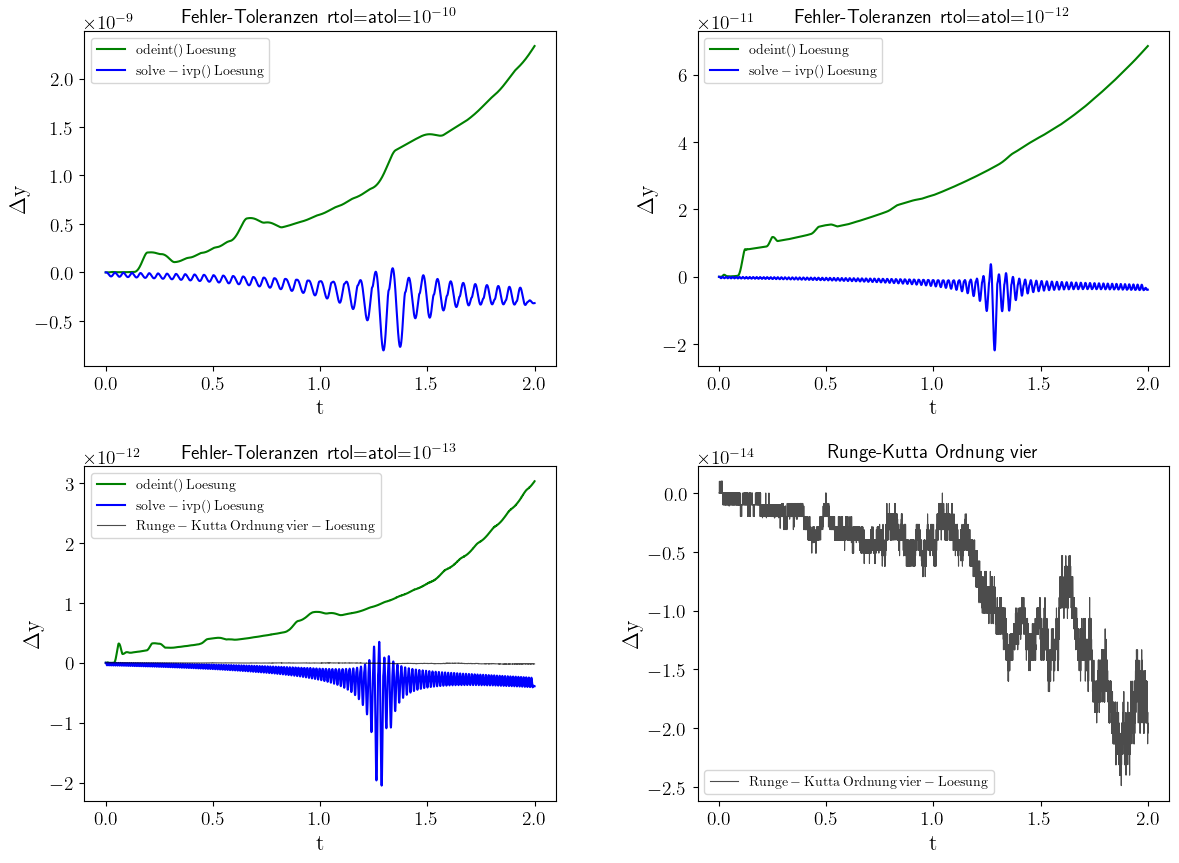

In [28]:
fig = plt.figure()                                                        # Hauptbild
gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], wspace=0.3, hspace=0.3)  # Anordnung der vier Unterbilder
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

ax1.set_title(r'Fehler-Toleranzen rtol=atol=$10^{-10}$')  # Titel der Abbildung in ax1
ax1.set_xlabel(r"$\rm t$")
ax1.set_ylabel(r"$\rm \Delta y$")
ax2.set_title(r'Fehler-Toleranzen rtol=atol=$10^{-12}$')  # Titel der Abbildung in ax2 
ax2.set_xlabel(r"$\rm t$")
ax2.set_ylabel(r"$\rm \Delta y$")
ax3.set_title(r'Fehler-Toleranzen rtol=atol=$10^{-13}$')  # Titel der Abbildung in ax3  
ax3.set_xlabel(r"$\rm t$")
ax3.set_ylabel(r"$\rm \Delta y$")
ax4.set_title(r'Runge-Kutta Ordnung vier')                # Titel der Abbildung in ax4  
ax4.set_xlabel(r"$\rm t$")
ax4.set_ylabel(r"$\rm \Delta y$")

l_width = 0.8                                             # Festlegung der Plot-Liniendicke  
alp = 0.7                                                 # Festlegung der Transparenz der Kurven

ax1.plot(tval, Loes_DGL_lam(tval) - Loes_DGL_num_odeint_F10[:,0],c="green", label=r'$\rm odeint() \, Loesung$')
ax1.plot(Loes_DGL_num_F10.t, Loes_DGL_lam(Loes_DGL_num_F10.t) - Loes_DGL_num_F10.y[0],c="blue", label=r'$\rm solve-ivp() \, Loesung$')
ax2.plot(tval, Loes_DGL_lam(tval) - Loes_DGL_num_odeint_F12[:,0],c="green", label=r'$\rm odeint() \, Loesung$')
ax2.plot(Loes_DGL_num_F12.t, Loes_DGL_lam(Loes_DGL_num_F12.t) - Loes_DGL_num_F12.y[0],c="blue", label=r'$\rm solve-ivp() \, Loesung$')
ax3.plot(tval, Loes_DGL_lam(tval) - Loes_DGL_num_odeint_F13[:,0],c="green", label=r'$\rm odeint() \, Loesung$')
ax3.plot(Loes_DGL_num_F13.t, Loes_DGL_lam(Loes_DGL_num_F13.t) - Loes_DGL_num_F13.y[0],c="blue", label=r'$\rm solve-ivp() \, Loesung$')
ax3.plot(data[:,1],data[:,6]-data[:,5], color="black", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Runge-Kutta \, Ordnung \, vier-Loesung$')
ax4.plot(data[:,1],data[:,6]-data[:,5], color="black", linewidth=l_width, linestyle='-', alpha=alp, label=r'$\rm Runge-Kutta \, Ordnung \, vier-Loesung$')

ax1.legend(frameon=True, loc="upper left",fontsize=10)  # Anordnung der Legende auf ax1
ax2.legend(frameon=True, loc="upper left",fontsize=10)  # Anordnung der Legende auf ax2
ax3.legend(frameon=True, loc="upper left",fontsize=10)  # Anordnung der Legende auf ax3
ax4.legend(frameon=True, loc="lower left",fontsize=10); # Anordnung der Legende auf ax4

## Anwendungsfall 

Wir betrachten im Folgenden die zeitliche Entwicklung des strategischen Verhaltens einer ganzen Population in einem wiederholten symmetrischen Spiel mit zwei Strategien. Wie im Python Notebook EvolutionSpiel1.ipynb (<A href="https://itp.uni-frankfurt.de/~hanauske/VPSOC/2025/jupyter/EvolutionSpiel1.html" target="_blank">View Notebook</A>, <A href="https://itp.uni-frankfurt.de/~hanauske/VPSOC/2025/jupyter/EvolutionSpiel1.ipynb" target="_blank">Download Notebook</A>) bereits dargestellt, wird der Populationsvektor $\vec{x}(t)$ durch folgende Gleichung bestimmt (hier $x(t)$, da es sich um ein symmetrisches Spiel mit zwei Strategien handelt):
$$
\begin{equation}
\frac{d x(t)}{dt} = \left[ (\$_{11} -  \$_{21}) (x-x^2) + (\$_{12} - \$_{22}) (1-2x+x^2) \right] \, x(t) \, =:\,g(x) 
\end{equation}
$$
$x(t)$, der Anteil der Spieler die zum Zeitpunkt $t$ die Strategie $s_1$ spielen, h&auml;ngt neben der Funktion $g(x)$ von dem Anfangswert $x(t=0)$ ab. In gewisser Weise kann man $x(t)$ als die gemischte Strategie $\tilde{s}$ der gesamten Population ansehen.

Die DGL hat die besprochene Form einer Differentialgleichung (DGL) erster Ordnung der Form 

$$
\begin{equation}
\dot{y}(t) = \frac{d y(t)}{dt} = f(t,y(t)) \quad, \, \hbox{mit:} \,\, a \leq t \leq b \, , \,\, y(a)=\alpha \quad,
\end{equation}
$$

wobei $y(t) = x(t)$ und $f(t,y(t)) = f(t,x(t)) = g(x(t)) =g(x)$.

Wir möchten nun die numerische Python Lösung des Hirschjagd-Spiels (a,b,c,d = 2,4,0,5) mit den Ergebnissen eines C++ Programms (siehe <A href="http://itp.uni-frankfurt.de/~hanauske/VPSOC/C++/evol1.cpp" target="_blank">evol1.cpp</A>) vergleichen.

Das C++ Programm löst eine Differentialgleichung der Form x'=g(x) mittels Runge-Kutta (Ordnung vier) Verfahrens. Die Lösung ist in eine Klasse ausgelagert, die die Zeitentwicklung im Intervall [ta,tb] berechnet. Der Konstruktor ist wie folgt aufgebaut: dsolve(Anfangszeit ta, Endzeit tb, Anzahl der Punkte N, Anfangswert alpha=x(a), Funktion $g(x)$). Die Vorlage dieses C++ Programms ist dem Projekt <A href="https://itp.uni-frankfurt.de/~hanauske/VPROG/V10/DieSchwingendeKette.html" target="_blank">Die schwingende Kette</A> der Vorlesung <A href="https://itp.uni-frankfurt.de/~hanauske/VPROG/index.html#V10" target="_blank">Einführung in die Programmierung für Studierende der Physik</A> entnommen.

In [34]:
data = np.genfromtxt("./evol1.dat") # mit dem C++ Programm generierte Loesung fuer x(0)=0.36 

In [35]:
def g(x,a,b,c,d):
    g=((a-c)*(x-x*x) + (b-d)*(1-2*x+x*x))*x
    return g

In [36]:
def DGL(x,t):
    dxdt = g(x,a,b,c,d)
    return dxdt

In [37]:
params = {
    'figure.figsize'    : [10,7],
#    'text.usetex'       : True,
    'axes.titlesize' : 16,
    'axes.labelsize' : 18,  
    'xtick.labelsize' : 16 ,
    'ytick.labelsize' : 16 
}
matplotlib.rcParams.update(params)

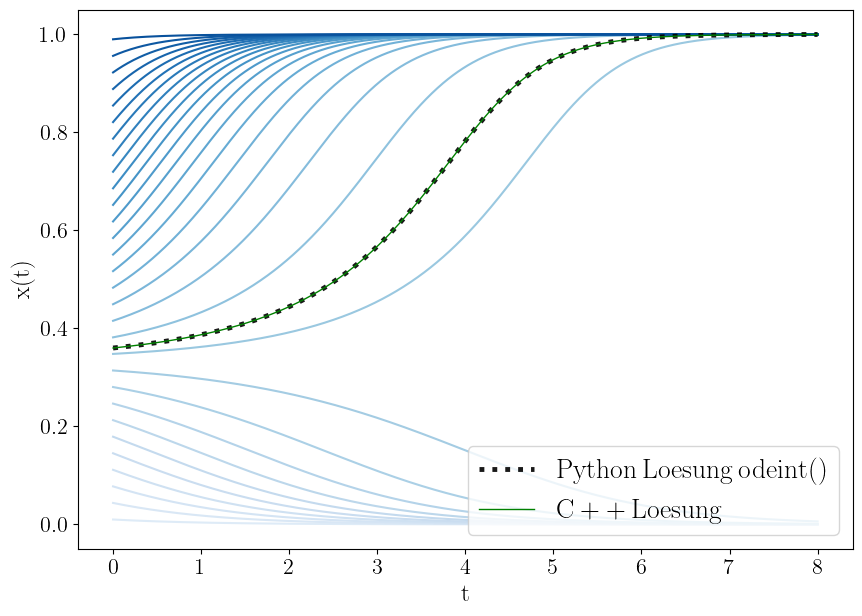

In [38]:
a,b,c,d = 2,4,0,5
tval = np.linspace(0, 8, 1000)
cmap = plt.cm.Blues 
numx0 = 30
x0=np.linspace(0.01,0.99,numx0)
line_colors = cmap(np.linspace(0,1,numx0+10))
plt.cla()
plt.ylabel(r"$\rm x(t)$")
plt.xlabel(r"$\rm t$")
j = 0
while j < numx0:
    Loes = integrate.odeint(DGL, x0[j], tval)
    plt.plot(tval,Loes,c=line_colors[j+5], linewidth=1.5, linestyle='-');
    j = j + 1
Loes = integrate.odeint(DGL, 0.36, tval)
plt.plot(tval,Loes,c="black", linewidth=3.5, linestyle=':', alpha=0.9, label=r'$\rm Python \, Loesung \, odeint()$')
plt.plot(data[:,1],data[:,2], c="green", linewidth=1.0, linestyle='-', label=r'$\rm C++ \, Loesung$')
plt.legend(frameon=True, loc="lower right",fontsize=20); 

## Aufgabe

Für den Fall (a,b,c,d = 0,2,-1,3) entsteht auch ein Koordinationsspiel, welches man jedoch analytisch lösen kann. Berechnen Sie die numerischen Lösungen in Python (odeint() und solve_ivp()) und in C++ und vergleichen Sie die numerischen Fehler.